<a href="https://colab.research.google.com/github/gauravzazz/TradingBot/blob/master/Reinforcement_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-gpu==1.15.0 tensorflow==1.15.0 stable-baselines gym-anytrading gym
!pip install finta

In [ ]:
# Gym stuff
import gym
import gym_anytrading
#Finta Library
from finta import TA
from gym_anytrading.envs import StocksEnv

from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import A2C

# Processing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [4]:
df = pd.read_csv('/content/Download Data - STOCK_US_XNYS_GME.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['Volume']=df['Volume'].apply(lambda x:float(x.replace(",","")) )
df.set_index('Date',inplace=True)
df.sort_values('Date',ascending=True, inplace=True)


In [5]:
#adding technical indicator
df['SMA']=TA.SMA(df,12)
df['RSI']=TA.RSI(df)
df['OBV']=TA.OBV(df)
#df['Boldinger']=TA.BBANDS(df)
df['MSD']=TA.MSD(df,12)
df['VZO']=TA.VZO(df)
#df['EBBP']=TA.EBBP(df)
df.fillna(0, inplace=True)

In [6]:
def add_signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume','SMA', 'RSI', 'OBV','MSD','VZO']].to_numpy()[start:end]
    return prices, signal_features

In [7]:
class MyCustomEnv(StocksEnv):
    _process_data = add_signals
    
env = MyCustomEnv(df=df, window_size=12, frame_bound=(12,50))

In [8]:
env.signal_features

array([[ 1.73000000e+02,  2.68485500e+06,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 1.73800000e+02,  1.23365200e+06,  0.00000000e+00,
         0.00000000e+00, -1.23365200e+06,  0.00000000e+00,
        -3.46480235e+01],
       [ 1.76000000e+02,  1.93023900e+06,  0.00000000e+00,
         7.95586207e+01,  6.96587000e+05,  0.00000000e+00,
         1.71664482e+01],
       [ 1.82600000e+02,  1.67600800e+06,  0.00000000e+00,
         7.77004062e+01, -9.79421000e+05,  0.00000000e+00,
        -1.54359623e+01],
       [ 1.80880000e+02,  1.19997700e+06,  0.00000000e+00,
         7.32919703e+01, -2.17939800e+06,  0.00000000e+00,
        -3.12417458e+01],
       [ 1.82550000e+02,  1.58964800e+06,  0.00000000e+00,
         7.95245435e+01, -5.89750000e+05,  0.00000000e+00,
        -2.07825492e+00],
       [ 1.84400000e+02,  2.07061800e+06,  0.00000000e+00,
         8.08752069e+01,  1.48086800e+06,  0.00000000e+00,
         2.3478155

In [9]:
env = gym.make('stocks-v0', df=df, frame_bound=(5,100), window_size=5)
# using open ai gym to create a environment, 'stocl-v0' is a default template created in anytrading package to trade. 
#Frame _bound represent the number of datapoint selected for training
# windows_size tells us about the number of data point to wait to make trade


In [10]:
env_maker = lambda: gym.make('stocks-v0', df=df, frame_bound=(5,100), window_size=5)
env = DummyVecEnv([env_maker])
model = A2C('MlpLstmPolicy', env, verbose=1) 
model.learn(total_timesteps=1000000)

Streaming output truncated to the last 5000 lines.
---------------------------------
| explained_variance | -283     |
| fps                | 257      |
| nupdates           | 137600   |
| policy_entropy     | 3.22e-05 |
| total_timesteps    | 688000   |
| value_loss         | 4.75e-09 |
---------------------------------
---------------------------------
| explained_variance | nan      |
| fps                | 257      |
| nupdates           | 137700   |
| policy_entropy     | 3.21e-05 |
| total_timesteps    | 688500   |
| value_loss         | 4.61e-10 |
---------------------------------
---------------------------------
| explained_variance | -83.7    |
| fps                | 257      |
| nupdates           | 137800   |
| policy_entropy     | 3.69e-05 |
| total_timesteps    | 689000   |
| value_loss         | 3.67e-09 |
---------------------------------
----------------------------------
| explained_variance | -2.72e+03 |
| fps                | 257       |
| nupdates           | 13790

info {'total_reward': 0.0, 'total_profit': 1.0, 'position': 0}


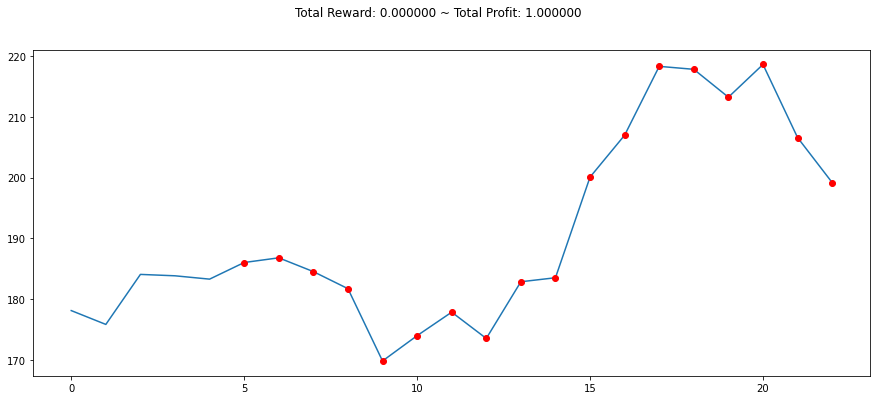

In [16]:
env = gym.make('stocks-v0', df=df, frame_bound=(5,110), window_size=5)
obs = env.reset()
while True: 
    obs = obs[np.newaxis, ...]
    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    if done:
        print("info", info)
        break
plt.figure(figsize=(15,6))
plt.cla()
env.render_all()
plt.show()